In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


# K-Means

In [16]:
class KMeans:
    def __init__(
        self,
        n_clusters: int,
        max_iter: int = 300,
        random_state: int | None = None,
        verbose: bool = False,
    ) -> None:
        self.n_clusters: int = n_clusters
        self.max_iter: int = max_iter
        self.random_state: int | None = random_state
        self.verbose: bool = verbose

    @staticmethod
    def euclidean_distance(
        x1: np.ndarray,
        x2: np.ndarray,
        squared: bool = False,
    ) -> float:
        res = ((x1 - x2) ** 2).sum(axis=1)
        if not squared:
            np.sqrt(res, res)
        return res

    def fit(self, X: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        n_samples = X.shape[0]
        # Random generator
        random_state = np.random.RandomState(self.random_state)

        # Initial centroids using K-Means++
        centers: np.ndarray = self._init_centroids(
            X,
            random_state=random_state,
        )

        if self.verbose:
            print("Initialization complete")

        centers_new: np.ndarray = np.zeros_like(centers)
        # Labels array initialized with -1
        labels: np.ndarray = np.full(n_samples, -1, dtype=np.int32)
        labels_old: np.ndarray = labels.copy()

        for i in range(self.max_iter):
            # Compute distances between each point and each centroid
            distances: np.ndarray = np.array(
                [self.euclidean_distance(x, centers) for x in X]
            )

            # Assign each point to the closest centroid
            labels: np.ndarray = np.argmin(distances, axis=1)

            # Compute new centroids as the mean of the points assigned to each centroid
            centers_new = np.array(
                [X[labels == i].mean(axis=0) for i in range(self.n_clusters)]
            )

            # Swap old and new centroids
            centers, centers_new = centers_new, centers

            if np.array_equal(labels, labels_old):
                if self.verbose:
                    print(f"Converged at iteration {i}: strict convergence")
                break
            labels_old = labels.copy()
        self.cluster_centers_ = centers
        self.labels_ = labels
        return self

    def _init_centroids(
        self,
        X: np.ndarray,
        random_state: np.random.RandomState,
    ) -> np.ndarray:
        n_samples, n_features = X.shape
        centers = np.empty((self.n_clusters, n_features), dtype=X.dtype)

        center_id = random_state.choice(n_samples)
        centers[0] = X[center_id]

        for i in range(1, self.n_clusters):
            # It makes more sense to use the squared distance here since we are using it 
            # to compute probabilities and not to compute the actual distance between points.
            # By squaring the distance we increase the probability of points that are
            # further away from the closest centroid.
            min_distances = np.array(
                [
                    np.min(self.euclidean_distance(x, centers[:i], squared=True))
                    for x in X
                ]
            )

            center_id = random_state.choice(
                n_samples, p=min_distances / min_distances.sum()
            )

            centers[i] = X[center_id]
        return centers

    def predict(self, X: np.ndarray) -> np.ndarray:
        distances = np.array(
            [self.euclidean_distance(x, self.cluster_centers_) for x in X]
        )
        return np.argmin(distances, axis=1)

# Dataset

In [17]:
import pandas as pd
from sklearn.decomposition import PCA

In [18]:
def get_data() -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv("db.csv")
    return df


def reduce_data(n_components: int, data: pd.DataFrame) -> np.ndarray:
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

In [19]:
data = get_data()
X = data.iloc[:, 1:]
labels = data.iloc[:, 0]
X = reduce_data(2, X)

l = preprocessing.LabelEncoder().fit_transform(labels)
print(l)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 4 4 5 5 5 4 4 4 5 5 5 4 4 0 3 5 5 5 5 5 5 0 0 5 5 4 4
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 6 6
 6 6 6 6]


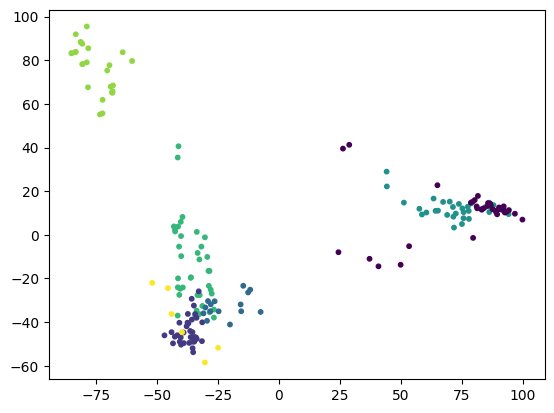

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=l, s=10)

Initialization complete
Converged at iteration 6: strict convergence
[2 2 3 3 3 3 3 3 2 3 2 3 3 3 3 3 0 0 4 0 4 0 0 0 0 4 5 5 5 5 5 0 0 5 0 0 0
 0 0 0 0 0 0 0 0 0 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 3
 2 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 1 1 1 2 2 2 1 1 1 3 3 0 0 1 1 1 1 1 1 4 4 1 1 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 5 0 5 2 2
 2 2 2 3]


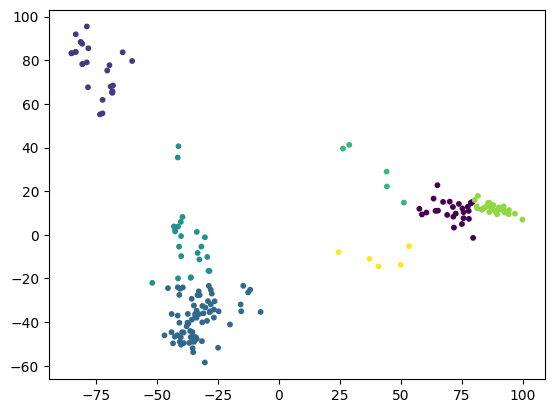

In [21]:
k = KMeans(n_clusters=2, verbose=True)
k.fit(X)
print(k.labels_)
plt.scatter(X[:, 0], X[:, 1], c=k.labels_, s=10)
# plt.scatter(k.cluster_centers_[:, 0], k.cluster_centers_[:, 1], c="red", marker="x")